# Analyzing the impact of economic data on education

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', rc={'figure.figsize':(12,8)})

## Import and clean data


In [2]:
# Import data

econ_data = pd.read_excel('data/pwt100.xlsx', sheet_name='Data') # Source: https://www.rug.nl/ggdc/productivity/pwt/

# get geographic region information: 
country_info = pd.read_csv('data/country_info.csv', usecols=['Country Code', 'Region', 'Income Group'])
econ_data = pd.merge(econ_data, country_info, left_on='countrycode', right_on='Country Code')
income_order = ['Low income', 'Lower middle income', 'Upper middle income', 'High income']

# get base data 
base_data = pd.read_csv('data/world_bank.csv')
base_data.set_index(['country', 'year'], inplace=True)

# get gdp growth
growth_data = pd.read_csv('data/gdp_growth.csv', skiprows=4)


For the economic data, we chose the Penn World Table dataset. First, it is freely available and alredy clean, so it does not need much preprocessing. Secondly, it covers broad metrics of all important countries that we need for our analysis. As secondary datasources, we use data from the world bank about a country's regional classification and income classification, which allows more granular differentiation. Further, we use data on annual gdp growth from the world bank which is not covered by the Penn World Table. 

In [3]:
econ_data.head()

,countrycode,country,currency_unit,year,rgdpe,rgdpo,pop,emp,avh,hc,...,pl_c,pl_i,pl_g,pl_x,pl_m,pl_n,pl_k,Country Code,Region,Income Group
0,ABW,Aruba,Aruban Guilder,1950,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABW,Latin America & Caribbean,High income
1,ABW,Aruba,Aruban Guilder,1951,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABW,Latin America & Caribbean,High income
2,ABW,Aruba,Aruban Guilder,1952,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABW,Latin America & Caribbean,High income
3,ABW,Aruba,Aruban Guilder,1953,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABW,Latin America & Caribbean,High income
4,ABW,Aruba,Aruban Guilder,1954,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABW,Latin America & Caribbean,High income


In [4]:
# Cleaning data

# Drop unnecessary or redundant columns
if 'currency_unit' in econ_data.columns:
    econ_data.drop(['currency_unit', 'xr', 'pl_con', 'pl_da', 'pl_gdpo', 'i_cig', 'i_xm', 'i_xr', 'i_outlier', 'i_irr', 'cor_exp', 'statcap', 'avh', 'irr', 'pl_c', 'pl_i', 'pl_g', 'pl_x', 'pl_m', 'pl_n', 'pl_k', 'rgdpna', 'rconna', 'rdana', 'rnna', 'rkna', 'rtfpna', 'rwtfpna', 'labsh', 'irr', 'delta', 'cgdpe', 'csh_i', 'csh_x', 'csh_m', 'country'], axis=1, inplace=True)
    econ_data.rename(columns = {'countrycode' : 'country'}, inplace=True)
    econ_data.set_index(['country', 'year'], inplace=True) 

# Deal with missing values

econ_data = econ_data[econ_data['rgdpe'].notna()]
econ_data['emp'] = econ_data['emp'].fillna(0)
econ_data = econ_data[econ_data['cgdpo'].notna()]

# growth data
if 'Country Name' in growth_data.columns:
    growth_data.drop(['Country Name', 'Indicator Name', 'Indicator Code', 'Unnamed: 65'], axis=1, inplace=True)
    growth_data=pd.melt(growth_data, id_vars='Country Code')
    growth_data.rename(columns={'Country Code' : 'country', 'variable' : 'year', 'value' : 'gdp_g'}, inplace=True)
    growth_data['year'] = pd.to_numeric(growth_data['year'])
    growth_data.set_index(['country', 'year'], inplace=True)
    growth_data.fillna(0, inplace=True)

# merge
econ_data = pd.merge(econ_data, growth_data, left_index=True, right_index=True)

# Creating new attributes 
econ_data['gdppc'] = econ_data['rgdpe']/econ_data['pop']
econ_data['rel_emp'] = econ_data['emp'] / econ_data['pop']
econ_data['gdppc_log'] = np.log(econ_data['gdppc'])

econ_data.shape

(9570, 22)

First, we drop some of the columns that were contained in the Penn World Table. That had several reasons: First we wanted to make the dataset more manageable. To achieve this, we dropped several of the columns we deemed irrelevant for the assignment. As we were already analyzing the impact of government spending on the completion rate, all variables that were connected to national accounts could be removd. Also, as the GDP data was already converted to USD levels, all exchange rate related information could be removed. Some variables were dummy variables, that showed with which method other datapoints were gathered. As we are not interested in reconstructing the data gathering, these variables could also be removed. Finally, we removed all information about price levels or expenditure categories, as we deemed these information not relevant to our analysis that was focused on gdp. 

We converted gdp growth data from a wide to a long format so we could merge it with our main dataset. 

There were several values missing in the dataset. We dropped every gdp related value that was missing or zero, as this was the datapoints we were most interested in. We also filled every employment value that was missing with zero, as this was a better way to deal with the issue than dropping the whole variable. We later excluded zero observations when analysing employment. After this, we still had several missing values in the dataset. Due to the fact, that the analysis of the completion rate was focused on the years 2000 - 2019, we can still work with the data. Most columns with missing values were not relevant for the analysis. 

We created several derived attributes. Their main goal was to make data more streamlined, especially gdp per person and relative employment. Due to some outliers in the GDP data (e.g. USA with a GDP of > 20trn USD), it is harder to compare other metrics with it so we introduced the gdp per capita. We are using relative employment as a rough proxy, by simply dividing the the number of people employed by the total population. Finally, we use a logarithmic gdp per capita for some analysis of its influence on the completion rate. 

In [5]:
# export data
econ_data.to_csv(path_or_buf='data/econ_data.csv')

# Data Exploration 

[Text(0.5, 1.0, 'GDP per capita development'), Text(0, 0.5, 'GDP per capita')]

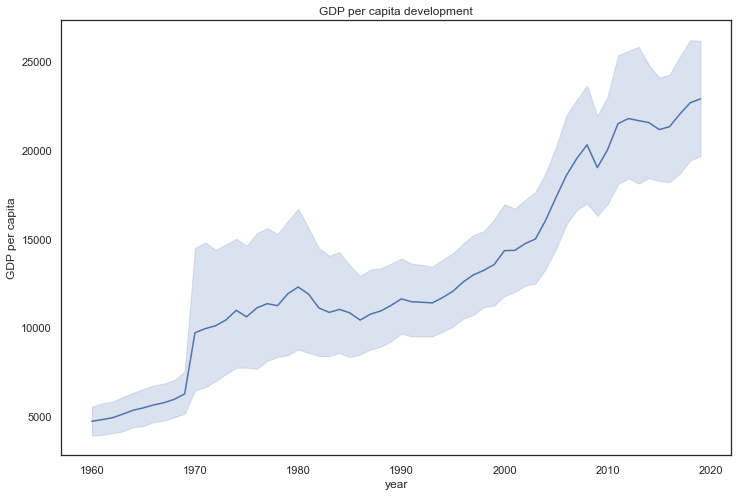

In [6]:
# Looking at the gdpc using the rgdpe:

ax = sns.lineplot(data=econ_data, x='year', y='gdppc')
ax.set(title='GDP per capita development', ylabel='GDP per capita')

The jump at 1970 is interesting, supposedly because not as many countries provide data before 1970. 
But the overall trend is positive. 

[Text(0.5, 1.0, 'Snapshot of the GDP Distribution in 2019'),
 Text(0, 0.5, 'Expenditure-side real GDP')]

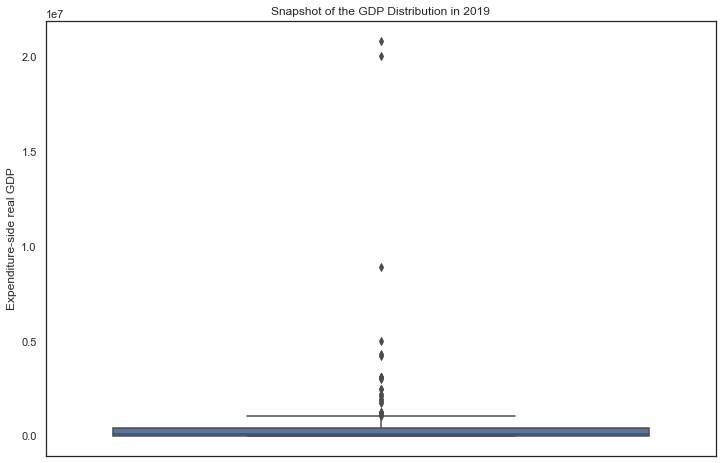

In [7]:
ax = sns.boxplot(data=econ_data[econ_data.index.isin([2019], level=1)], y='rgdpe')
ax.set(title='Snapshot of the GDP Distribution in 2019', ylabel='Expenditure-side real GDP')


The distribution of the real GDP shows many outliers at the top, which is as expected. 

[Text(0.5, 1.0, 'GDP per capita distribution in 2019'),
 Text(0, 0.5, 'GDP per capita')]

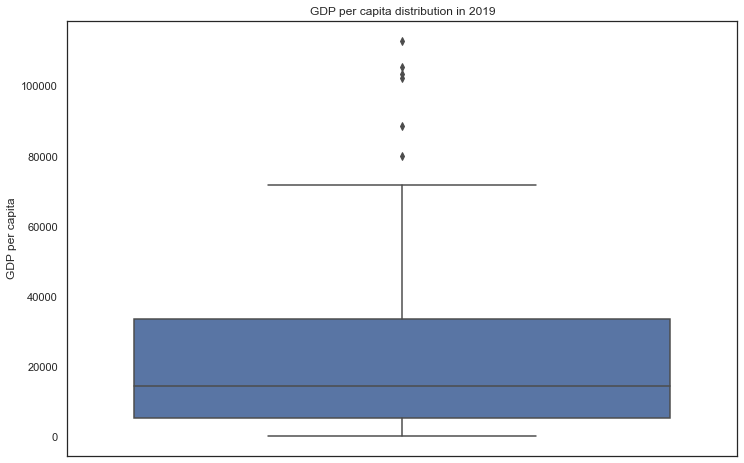

In [8]:
ax = sns.boxplot(data=econ_data[econ_data.index.isin([2019], level=1)], y='gdppc')
ax.set(title='GDP per capita distribution in 2019', ylabel='GDP per capita')

The distribution of the GDP per capita is interesting: There are not as many outliers as in the overall GDP distribution. However, the outliers are still larger than the 4x median.

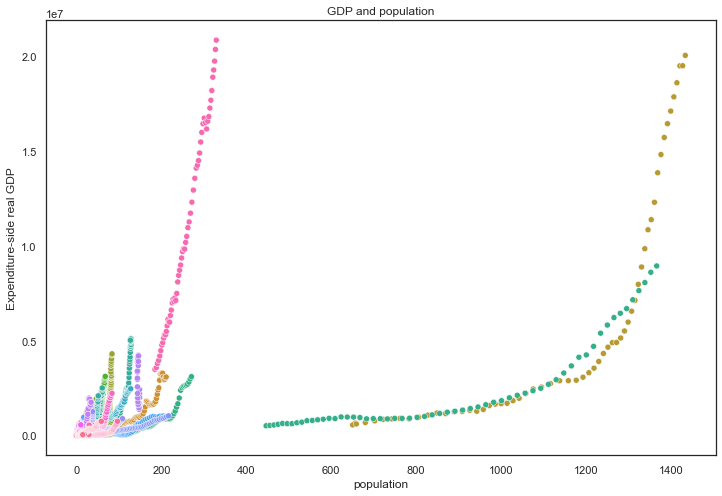

In [9]:
ax = sns.scatterplot(data=econ_data, x='pop', y='rgdpe', hue='country')
ax.set(title='GDP and population', xlabel='population', ylabel='Expenditure-side real GDP')
plt.legend([],[], frameon=False)

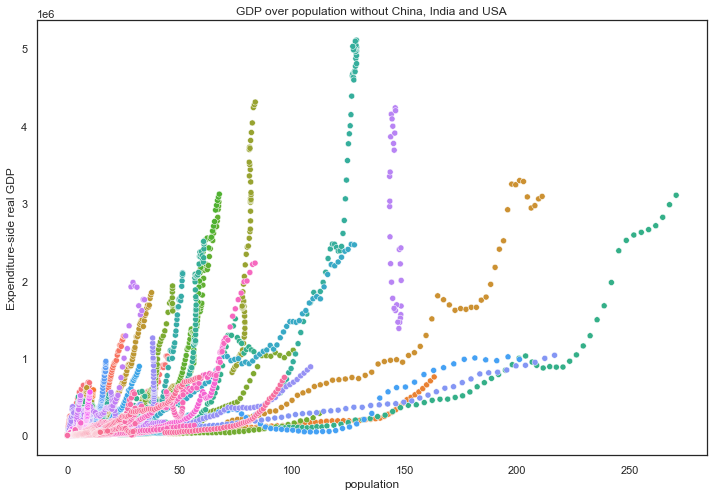

In [10]:
ax = sns.scatterplot(data=econ_data[~econ_data.index.isin(['CHN', 'IND', 'USA'], level=0)], x='pop', y='rgdpe', hue='country')
ax.set(title='GDP over population without China, India and USA', xlabel='population', ylabel='Expenditure-side real GDP')
plt.legend([],[], frameon=False)

As expected, the population plot is strongly dominated by China, India and the USA. If we remove the outliers it looks like the gpd has been increasing with an increasing population, at least for countries with a high population. 

[Text(0.5, 1.0, 'Relative Employment'),
 Text(0, 0.5, 'Relative employment'),
 Text(0.5, 0, 'year')]

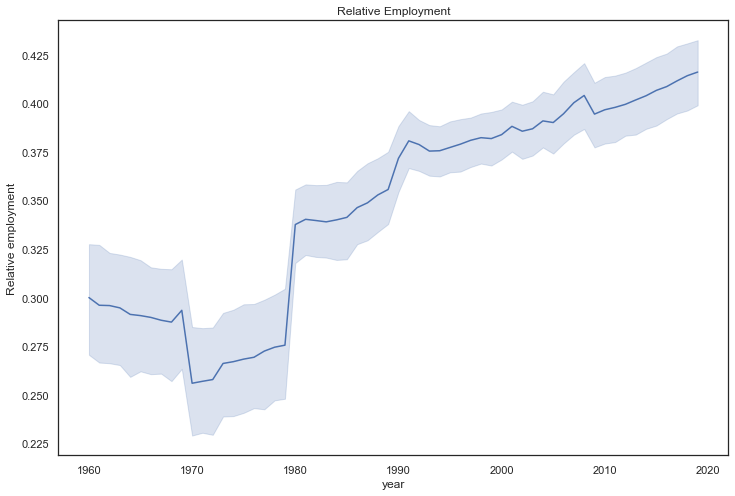

In [11]:
# Looking at the average employment: emp is in absolute numbers, so let's simply divide by population to have a relative figure
ax = sns.lineplot(data=econ_data, x='year', y='rel_emp')
ax.set(title='Relative Employment', ylabel='Relative employment', xlabel='year')

Looking at the underlying data it shows, that there are only up to 75 observations for data before 1960 and another discrepancy of available data for 1970. This does not conflict with the goal of figuring out how the gdp influences graduation rates. 

<AxesSubplot:xlabel='year', ylabel='rel_emp'>

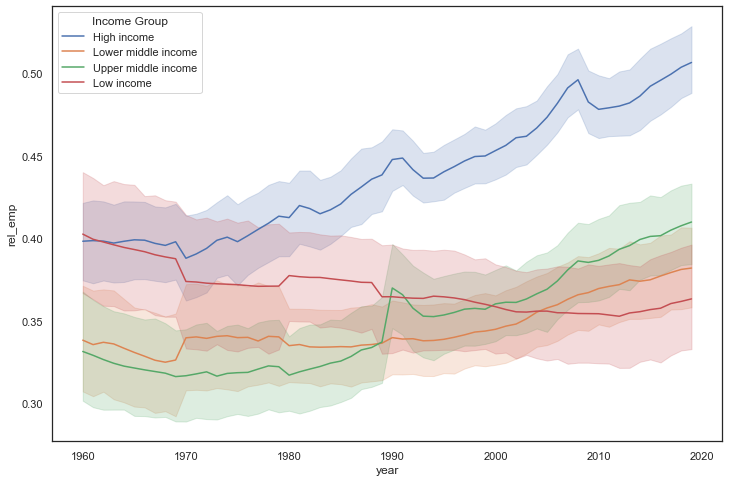

In [12]:
# Looking at the relative employment in relation to income groups:
sns.lineplot(data=econ_data[econ_data['rel_emp'] != 0], x='year', y='rel_emp', hue='Income Group')

Interesting to see, that the higher income group has a far higher relative employment than the lower & middle income groups, while it has been differently from the 1950s. It is also interesting to see that the low income group had a higher relative employment than the upper and lower middle income groups until the mid 2000s. 

[Text(0.5, 0, 'relative employment'), Text(0, 0.5, 'GDP per capita')]

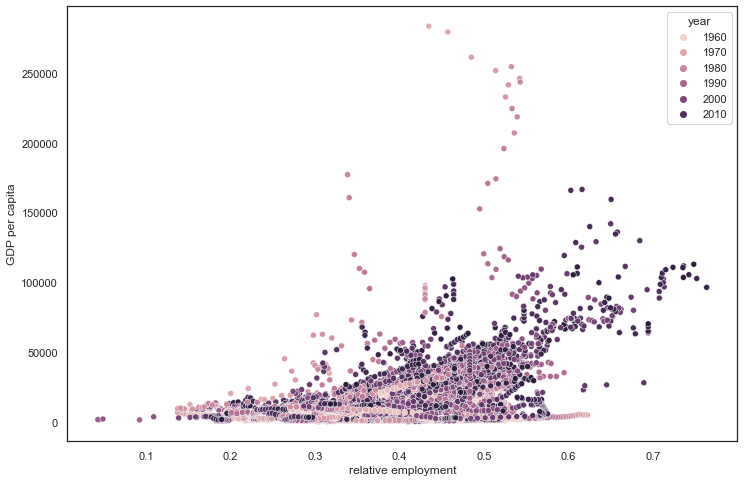

In [13]:
# filtering out 0 rel_emp values
ax = sns.scatterplot(data=econ_data[econ_data['rel_emp'] != 0], x='rel_emp', y='gdppc', hue='year') 
ax.set(xlabel='relative employment', ylabel='GDP per capita')

Generally, the graph gets 'darker' the higher the relative employment is, analogue to the previous plot. There are some 'outliers' with a GDP per person > 150000, which have mostly occured before around 2000. 

[Text(0, 0.5, 'Human capital')]

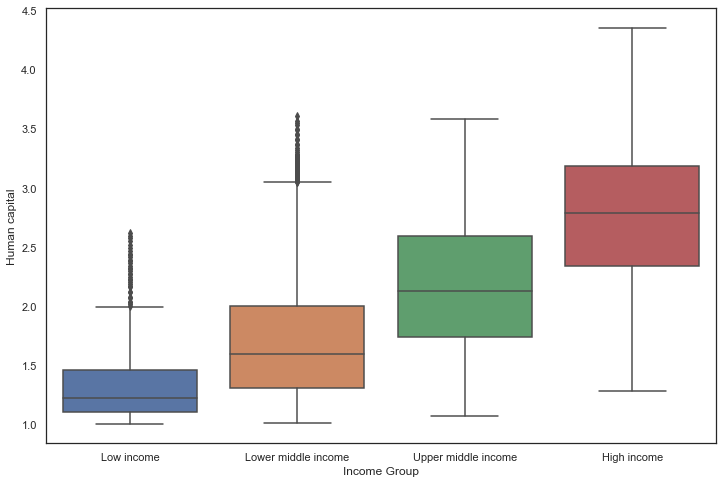

In [14]:
# Looking at the human capital, which is a first proxy to look at the influence of gdp on primary graduation rate
ax = sns.boxplot(data=econ_data, y='hc', x='Income Group', order=income_order)
ax.set(ylabel='Human capital')

Unsurprisingly, the higher the Income Group of a country the higher the human capital index, although there are outliers especially in the upper middle and high income group with a low hc. Interesting. 

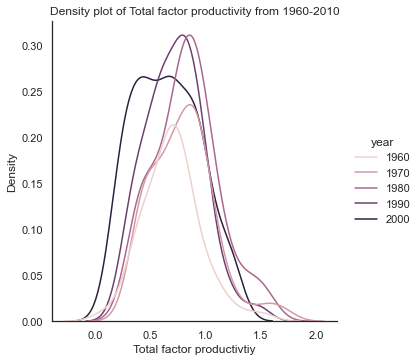

In [15]:
# ctfp displot
ax = sns.displot(data=econ_data[econ_data.index.isin(np.arange(1960, 2010, 10), level=1)], x='ctfp', kind='kde', hue='year')
ax.set(title='Density plot of Total factor productivity from 1960-2010', xlabel='Total factor productivtiy')

The distribution of the total factor productivity has been shifting since the 1960s. It's normal distribution got denser, but still has some outliers at the top. 

[Text(0.5, 1.0, 'Relation between GDP per capita and the share of household consumption of the total GDP'),
 Text(0.5, 0, 'GDP per capita'),
 Text(0, 0.5, 'Share of household consumption')]

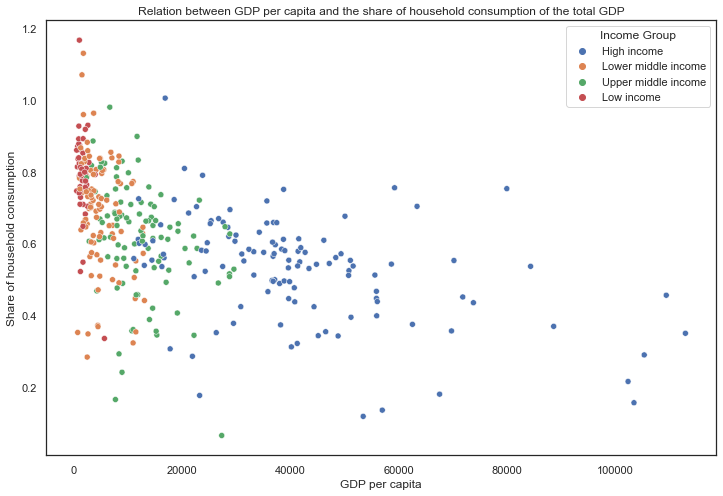

In [35]:
# csh_c & gdppc
ax = sns.scatterplot(data=econ_data[econ_data.index.isin([2000, 2019], level=1)], x='gdppc', y='csh_c', hue='Income Group') 
ax.set(title='Relation between GDP per capita and the share of household consumption of the total GDP', xlabel='GDP per capita', ylabel='Share of household consumption')

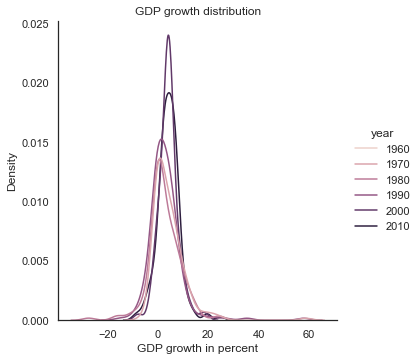

In [17]:
# GDP growth
ax = sns.displot(data=econ_data[econ_data.index.isin(np.arange(1960, 2011, 10), level=1)], x='gdp_g', kind='kde', hue='year', warn_singular=False)
ax.set(title='GDP growth distribution', xlabel='GDP growth in percent')

The gdp growth has a normal distribution, with few outliers at top and bottom. Over the years, the distribution shifted to the right.  
Next we look at the human capital: We use it as a first estimate of the influence of economic data on the graduation rate. 

<AxesSubplot:>

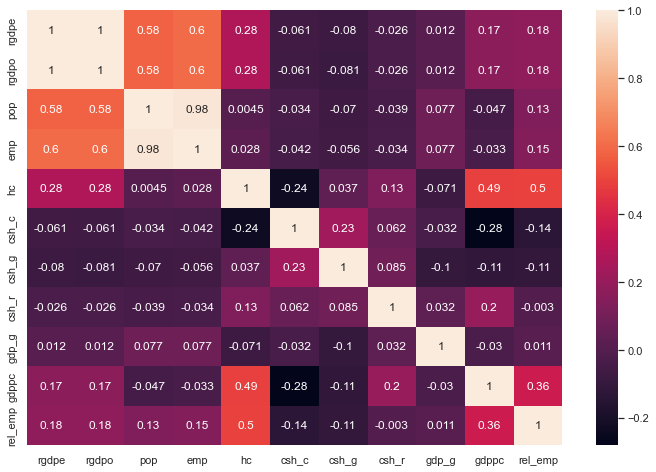

In [18]:
# Look at correlations to find out how the variables interact with a focus on relative attributes:
sns.heatmap(econ_data[['rgdpe', 'rgdpo', 'pop', 'emp', 'hc', 'csh_c', 'csh_g', 'csh_r', 'gdp_g', 'gdppc', 'rel_emp']].corr(), annot=True)

The correlation heatmap shows that human capital (hc) shows a strong positive correlation with relative employment and the gdp per person. It also correaltes with rgdpe and rgdpo, while this could be due to outliers. We'll check this in a next step. Interestingly, human capital is negatively correlated with the share of household consumption (csh_c), while the share of government consumption (csh_g) shows a very low correlation, which is a little bit surprising. 

# Economic datas impact on primary graduation rate

In [19]:
# Merging data
data = pd.merge(econ_data, base_data, left_index=True, right_index=True)
data.head()

rgdpe        rgdpo       pop       emp  hc         ccon  \
country year                                                                  
ABW     2000  4031.134277  4129.512695  0.090853  0.041900 NaN  2438.687012   
        2001  4122.958496  4728.453125  0.092898  0.042808 NaN  2538.510986   
        2002  4101.703125  3555.261230  0.094992  0.043736 NaN  2604.543701   
        2003  4209.140137  3701.983643  0.097017  0.044632 NaN  2707.093018   
        2004  4548.991211  4227.812012  0.098737  0.045385 NaN  2775.177979   

                      cda        cgdpo            cn        ck  ...  \
country year                                                    ...   
ABW     2000  3793.475098  4519.512695  18856.412109  0.000237  ...   
        2001  3939.204590  4979.928223  19783.585938  0.000240  ...   
        2002  4212.508301  3924.565186  20915.601562  0.000254  ...   
        2003  4471.079590  4053.201660  22329.816406  0.000270  ...   
        2004  4643.457520  4531.297852  23898.250000  0.000285  ...   

              out_school  first_grade_percentage  overage_percentage  \
country year                                                           
ABW     2000       134.0               106.07735            11.25985   
        2001        28.0                     NaN            12.57948   
        2002       161.0                     NaN            14.07520   
        2003       301.0               100.33333            13.95372   
        2004       200.0               101.67673            14.54099   

              grade_5_percentage  last_grade completion_rate   pupils  \
country year                                                            
ABW     2000           95.905182   95.868622       97.142860   9263.0   
        2001           95.332321   94.048683       94.404068   9436.0   
        2002           94.846130   93.863274       94.755241   9840.0   
        2003           94.920090   94.274101       90.215919   9897.0   
        2004           93.996582   93.659683       90.559898  10185.0   

             repeater_percentage  enrollment_gross_percentage  \
country year                                                    
ABW     2000             7.58933                   110.788177   
        2001             8.29801                   109.440964   
        2002             7.92683                   111.010834   
        2003             8.96231                   109.214302   
        2004             8.52234                   110.839050   

              enrollment_net_percentage  
country year                             
ABW     2000                   98.08635  
        2001                   94.53929  
        2002                   95.31814  
        2003                   93.93070  
        2004                   94.63489  

[5 rows x 34 columns]

[Text(0.5, 1.0, 'Completion rate development'),
 Text(0, 0.5, 'Completion rate'),
 Text(0.5, 0, 'year'),
 (2000.0, 2019.0)]

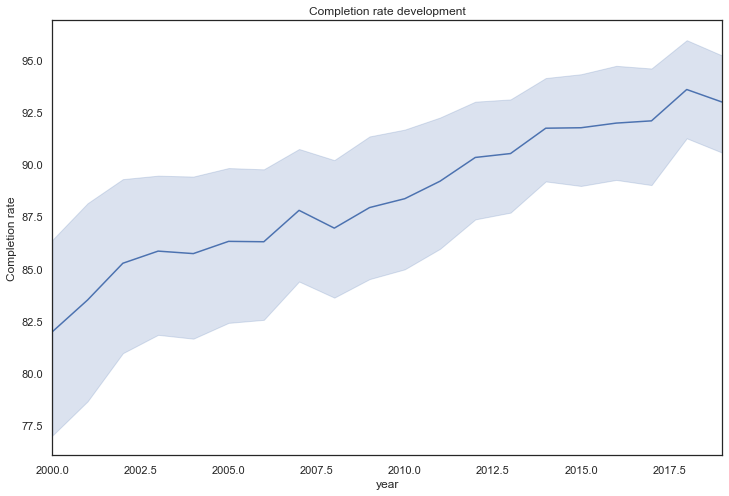

In [20]:
# look at the development of completion rate 
ax = sns.lineplot(data=data, x='year', y='completion_rate')
ax.set(title='Completion rate development', ylabel='Completion rate', xlabel='year', xlim=(2000, 2019))

The overall trend of the completion rate is positive. 

[Text(0.5, 1.0, 'Completion rate and Income groups'),
 Text(0, 0.5, 'Completion rate'),
 (0.0, 110.0),
 (2000.0, 2019.0)]

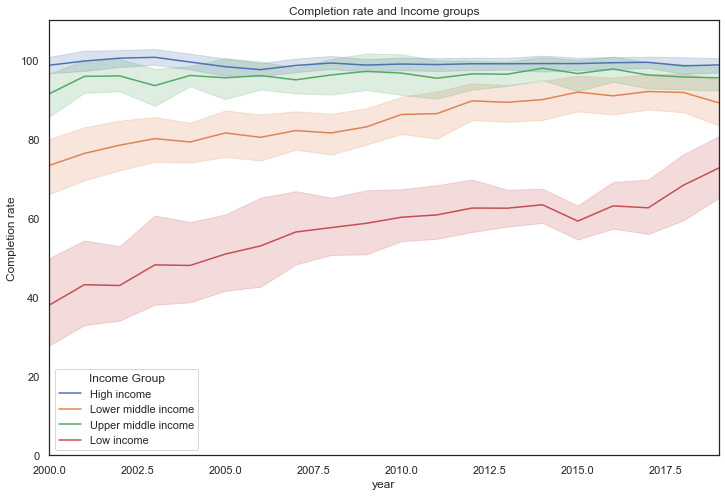

In [21]:
ax = sns.lineplot(data=data, x='year', y='completion_rate', hue='Income Group')
ax.set(title='Completion rate and Income groups', ylabel='Completion rate', ylim=(0, 110), xlim=(2000, 2019))

The trend is pretty clear: The higher the income group, the higher the completion rate. 

<AxesSubplot:>

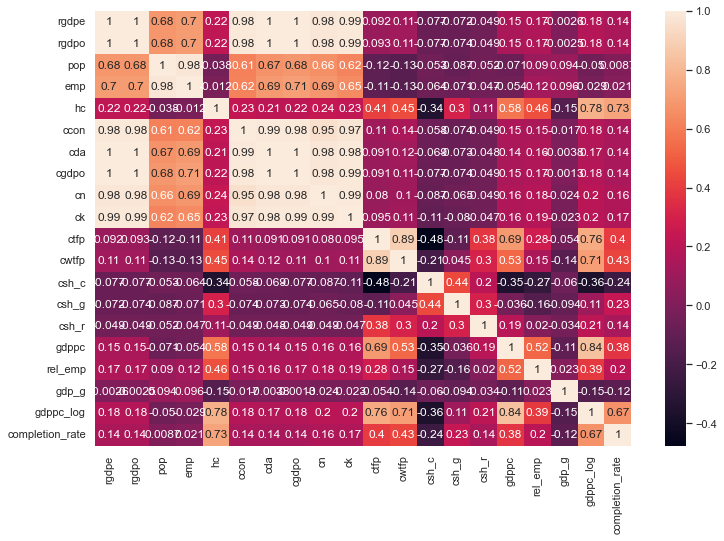

In [45]:
sns.set(style='white', rc={'figure.figsize':(12,8)})
sns.heatmap(data[['rgdpe', 'rgdpo', 'pop', 'emp', 'hc', 'ccon', 'cda', 'cgdpo', 'cn',
       'ck', 'ctfp', 'cwtfp', 'csh_c', 'csh_g', 'csh_r', 'Country Code',
       'Region', 'Income Group', 'gdppc', 'rel_emp', 'gdp_g', 'gdppc_log', 'completion_rate']].corr(), annot=True)

Looking especially at the completion rate, the direction of the correlations with the economic variables are largely similar with the previously discussed correlations with the human capital. We can see that the completion rate has a roughly equal correlation with the different gdp measurements (rgdpe, rgdpo, ccon, cda, cgdpo) which is as expected. The completion rate does barely correlate with the population or the absolute employment, but it shows a stronger correlation with the TFP level and the welfare relevant TFP levels (ctfp and cwtfp). There is a negative correlation with the share of household consumption (csh_c), which is, again, interesting. There is also a negative correlation with the annual gdp growth (gdp_g), which is also rather unexpected. There is a weaker correlation with the gdp per person and the relative employment. Further, there is a strong correlation between the completion rate and the log transformed gdp per person. 

[Text(0.5, 1.0, 'Completion rate and GDP per capita'),
 Text(0.5, 0, 'GDP per capita'),
 Text(0, 0.5, 'Completion rate')]

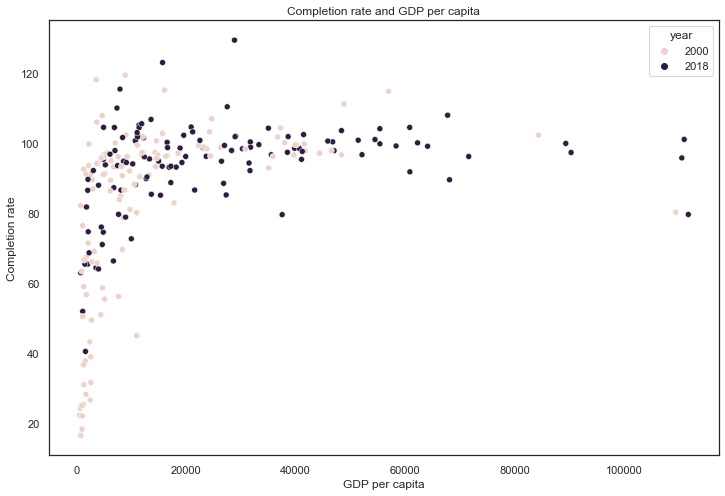

In [23]:
# 2018 completion rate and gdppc:
ax = sns.scatterplot(data=data[data.index.isin([2000, 2018], level=1)], x='gdppc', y='completion_rate', hue='year')
ax.set(title='Completion rate and GDP per capita', xlabel='GDP per capita', ylabel='Completion rate')

There is a logarithmic relationship between gdppc and completion rate, which is quite interesting. There are some outliers with a high gdppc, but a comparatively lower completion rate. 

[None,
 Text(0.5, 1.0, 'GDP per capita and completion rate on logarithmic x-axis'),
 Text(0.5, 0, 'GDP per capita'),
 Text(0, 0.5, 'Completion rate')]

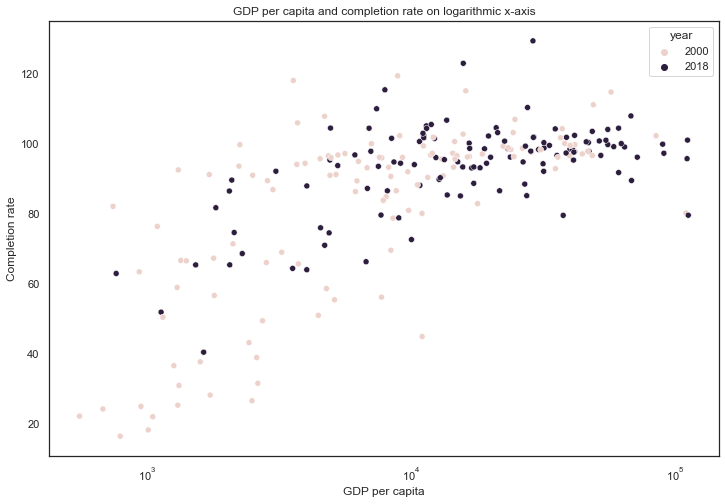

In [24]:
ax = sns.scatterplot(data=data[data.index.isin([2000, 2018], level=1)], x='gdppc', y='completion_rate', hue='year')
ax.set(xscale="log", title='GDP per capita and completion rate on logarithmic x-axis', xlabel='GDP per capita', ylabel='Completion rate')

[Text(0.5, 1.0, 'Total factor productivity levels and completion rate'),
 Text(0.5, 0, 'Total factor productivtiy level'),
 Text(0, 0.5, 'Completion rate')]

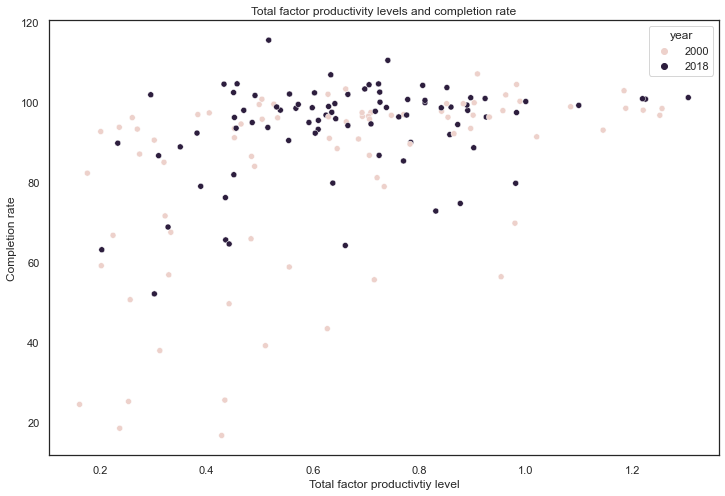

In [31]:
# completion rate and ctfp: 
ax = sns.scatterplot(data=data[data.index.isin([2000, 2018], level=1)], x='ctfp', y='completion_rate', hue ='year')
ax.set(title='Total factor productivity levels and completion rate', xlabel='Total factor productivtiy level', ylabel='Completion rate')

The relationship is not logarithmic but rather linear. 

[Text(0.5, 1.0, 'Welfare relevant total factor productivity level and completion rate'),
 Text(0.5, 0, 'Welfare relevant total factor productivity level'),
 Text(0, 0.5, 'Completion rate')]

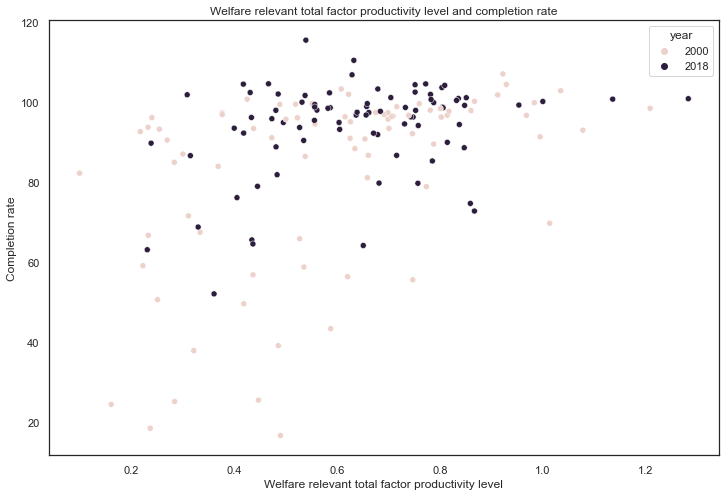

In [26]:
ax = sns.scatterplot(data=data[data.index.isin([2000, 2018], level=1)], x='cwtfp', y='completion_rate', hue='year') 
ax.set(title='Welfare relevant total factor productivity level and completion rate', xlabel='Welfare relevant total factor productivity level', ylabel='Completion rate')

Not much difference between ctfp and cwtfp, unsuprisingly as they have a 0.89 correlation.

[Text(0.5, 1.0, 'Share of government consumption of GDP and completion rate'),
 Text(0.5, 0, 'Share of government consumption'),
 Text(0, 0.5, 'Completion rate')]

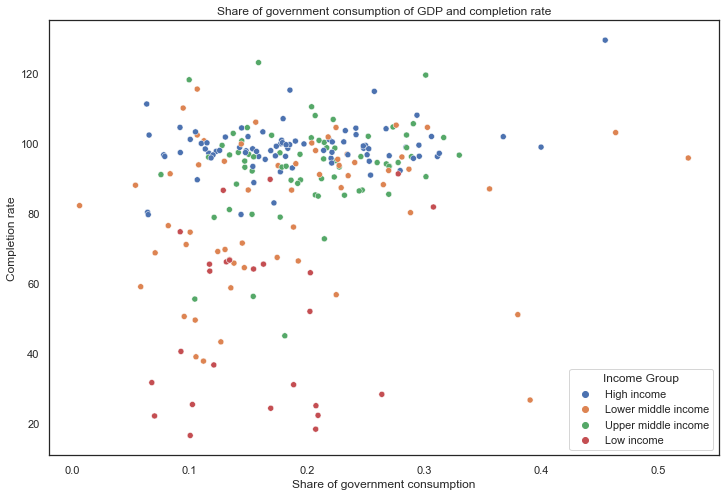

In [47]:
ax = sns.scatterplot(data=data[data.index.isin([2000, 2018], level=1)], x='csh_g', y='completion_rate', hue='Income Group') 
ax.set(title='Share of government consumption of GDP and completion rate', xlabel='Share of government consumption', ylabel='Completion rate')

This graphs shows the negative correlation between the share of household consumption and the completion rate. 

[Text(0.5, 1.0, 'Annual GDP growth and completion rate'),
 Text(0.5, 0, 'Annual GDP growth in percent'),
 Text(0, 0.5, 'Completion rate')]

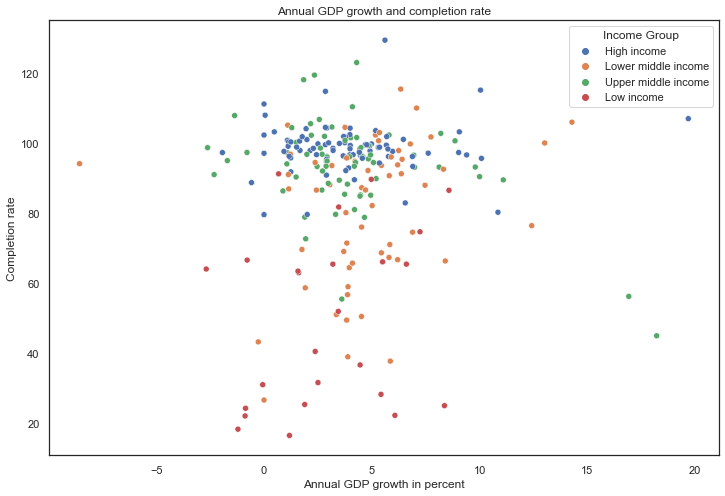

In [28]:
# Gdp growth and completion rate
ax = sns.scatterplot(data=data[data.index.isin([2000, 2018], level=1)], x='gdp_g', y='completion_rate', hue='Income Group') 
ax.set(title='Annual GDP growth and completion rate', xlabel='Annual GDP growth in percent', ylabel='Completion rate')

Also, not a 'clear' relationship here. One can see the slightly negative correlation. 

[Text(0.5, 1.0, 'Relative employment and completion rate'),
 Text(0.5, 0, 'Relative employment'),
 Text(0, 0.5, 'Completion rate')]

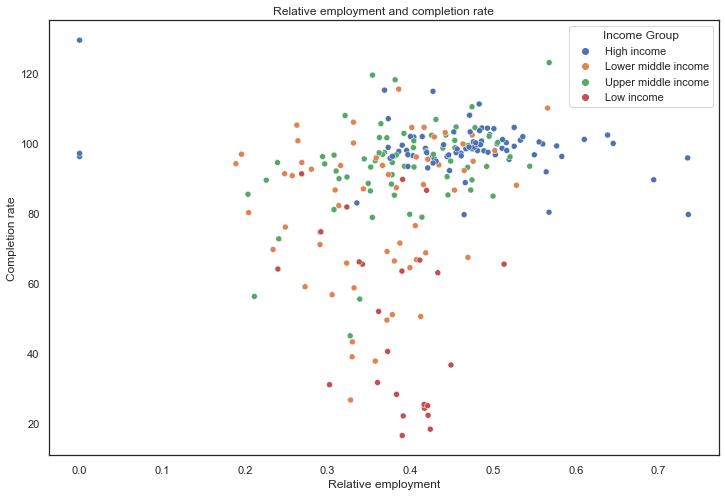

In [29]:
# Relative employment and completion rate
ax = sns.scatterplot(data=data[data.index.isin([2000, 2018], level=1)], x='rel_emp', y='completion_rate', hue='Income Group')
ax.set(title='Relative employment and completion rate', xlabel='Relative employment', ylabel='Completion rate')

You can see that there are some rough clusters of countries in one income group, but it is hard to make out a strong relationship between the relative employment and the completion rate. 

Concludingly, the data visualization and exploration shows that there is a strong relationship between the log GDP per capita and the completion rate. There are some other relationships, but the log GDP per capita is by far the strongest.

# Description

In [30]:
# econ_data.shape

Dimensions: 10226 x 21

- **country**
    - *3-letter ISO country code*
- **year**
- **rgdpe**
    * Expenditure-side real GDP at chained PPPs (in mil. 2017USD)
- **rgdpo**
    * Output-side real GDP at chained PPs (in mil. 2017USD)
- **pop**
    * The population of a country (in millions)
- **emp**
    * Number of persons engaged (in millions)
- **hc**
    * Human capital index: Based on years of schooling and returns to education (measure by Penn World Table)
- **ccon**
    * Real consumption of households and government at current PPPs (in mil. 2017USD)
- **cda**
    * Real domestic absorption (real consumption plus investment) at current PPPs (in mil 2017 USD)
- **cgdpo** 
    * Outputside real GDP at current PPPs (in mil. 2017USD)
- **cn**
    * Capital Stock at current PPPs (in mil. 2017USD)
- **ck**
    * Capital service levels at current PPPs (USA=1)
- **ctfp**
    * Total factor productivity levels at current PPPs (USA=1)
- **cwtfp**
    * Welfare-relevant total factor productivity levels at current PPPs (USA=1)
- **csh_c**
    * Share of household consumption at current PPPs
- **csh_g**
    * Share of government consumption at current PPPs
- **csh_r**
    * Share of residual trade and GDP statistical discrepancy at current PPPs 
- **rel_emp**
    * The percentage of persons engaged relative to the population (emp/pop)
- **gdpg**
    * Annual gdp growth


# Main question about the data

* **Which economic metrics influence the graduation rate? How do they influence it?**
   
We want to understand what influences the primary school graduation rate. Our hypothesis was, that the more income a country has, the higher its graduation rate as presumably its spending on education should be proportional to its income. As we already analyzed government expenditure, we focused on macroeconomic figures, that are somewhat independent from the government itself. We found that there is a relationship between the gdp per capita and the completion rate. We also found that the total factor productivity is correlated with the completion rate. The share of government consumption of the total gdp also influences the graduation rate, but not as much as expected. The answers make overall sense, but some aspects of them were surprising. 
    

We didn't encounter many difficulties when analyzing the economic data. The main issue was to understand the domain specific terminology (e.g. total factor productivity) and how they influence the completion rate. 

The key insight was that the completion rate has a strong relationship with the log GDP per capita. 

We didn't find see biases in the economic data. We assumed that the Penn World Table data has been diligently and neutrally compiled. During the pre-filtering of attributes during data cleaning, we could have introduced some bias as we have made some ex ante assumptions about the attributes and their relationship to the completion rate. We could have missed some confounding variables, but as we only considered using 'hard' gdp or population data and derivatives, we do not expect that this decision has introduced a bias into the analysis.

During this exercise we could improve our knowledge of python and especially seaborn as a useful tools for visualizations. Also, as a team exericse, we could improve our communication and coordination skills.